<h1>Финальный проект</h1>

<h3>Неделя 3. Прогнозирование ряда со сложной сезонностью </h3>

In [19]:
import numpy as np
import sys
import warnings
from tqdm import tqdm

import pandas as pd
from pandas.plotting import register_matplotlib_converters

import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

import datetime

import matplotlib.pyplot as plt

<h3>Считывание данных</h3>
Будем прогнозировать поездки в ячейке, содержащей Эмпайр Стейт Билдинг. Найдем нужный регион в таблице регионов и получим его границы.

In [2]:
#координаты ESB
target = (40.748441, -73.985664)
bins = pd.read_csv('regions.csv',sep=';')
target_region = bins.loc[(bins.west<=target[1])&(bins.east>target[1])&(bins.south<=target[0])&(bins.north>target[0])]
target_region = list(target_region.iloc[0])[1:]

Считаем данные начиная с даты start=февраль 2016 и заканчивая end=июнь 2016 в одну таблицу.

In [57]:
from IPython.display import clear_output

def filter_datetime(x):
    try:
        return datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    except:
        return np.nan
    
start = datetime.datetime.strptime('2016-2','%Y-%m')
end = datetime.datetime.strptime('2016-6','%Y-%m')
#большая таблица, в которую будут записанны все данные
raw = pd.DataFrame()
for current in range(start.month-1, (end.year-start.year)*12+end.month):
    
    #считываем файлы в цикле
    clear_output()
    print('Считывание yellow_tripdata_{0}-{1:0>2}.csv'.format(start.year+current//12,current%12+1))
    tmp = pd.read_csv('yellow_tripdata_{0}-{1:0>2}.csv'.format(start.year+current//12,current%12+1))
          
    clear_output()      
    print('Обработка yellow_tripdata_{0}-{1:0>2}.csv'.format(start.year+current//12,current%12+1))
          
    #сразу удаляем ненужные столбцы
    tmp = tmp[['tpep_dropoff_datetime','tpep_pickup_datetime',
               'passenger_count','trip_distance','pickup_longitude',
               'pickup_latitude']]
    
    #парсим ячейки со временем     
    tmp['tpep_dropoff_datetime'] = tmp['tpep_dropoff_datetime'].map(filter_datetime)
    tmp['tpep_pickup_datetime'] = tmp['tpep_pickup_datetime'].map(filter_datetime)
    tmp.dropna()
   
        
    #считаем длительность поездки
    tmp['duration'] = tmp['tpep_dropoff_datetime']-tmp['tpep_pickup_datetime']
    
    #удаляем поездки с нулевой длительностью
    tmp = tmp.loc[tmp['duration'] != datetime.timedelta(0)]
    
    #удаляем поездки с нулевым количеством пассажиров
    tmp = tmp.loc[tmp['passenger_count'] > 0]

    #удаляем поездки с нулевой дистанцией
    tmp['trip_distance'] = tmp['trip_distance'].map(lambda x: x if (isinstance(x,int) or isinstance(x,float)) else np.nan)
    tmp.dropna()                                               
    tmp = tmp.loc[(tmp['trip_distance'] > 0) & (tmp['trip_distance'] < 100)]

    #добавляем данные в большую таблицу
    raw = raw.append(tmp.loc[(tmp['pickup_longitude'] > target_region[0]) &
                             (tmp['pickup_longitude'] < target_region[1]) &
                             (tmp['pickup_latitude'] > target_region[2]) &
                             (tmp['pickup_latitude'] < target_region[3])])
               
clear_output()     
print('Размер прочитанных данных:', raw.shape)
    

Размер прочитанных данных: (2524119, 7)


In [58]:
#добавим в данные столбец, содержащий количество часов от начала отсчета (00:00:00 01.02.2016)
raw['pickup_hour'] = raw['tpep_pickup_datetime'].map(lambda x: (x-datetime.datetime(2016,2,1)).total_seconds()/3600)

In [59]:
#удаляем все столбцы, кроме времени начала поездки
raw_h = raw[['pickup_hour']]

In [60]:
raw_h.describe()

,pickup_hour
count,2.524119e+06
mean,1.770131e+03
std,1.043402e+03
min,1.111111e-03
25%,8.763504e+02
50%,1.737642e+03
75%,2.662177e+03
max,3.623999e+03


In [61]:
#получим количество часов в рассматриваемом интервале
bins = datetime.datetime.strptime('2016-7-1','%Y-%m-%d') - datetime.datetime.strptime('2016-2-1','%Y-%m-%d')
bins = int(bins.total_seconds()/3600)
bins



3624

In [64]:
print(raw_h.shape)
raw_h.pickup_hour = raw_h.pickup_hour.map(lambda x: x if isinstance(x,float) else np.nan)
raw_h.dropna(inplace=True)
print(raw_h.shape)

(2524119, 1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2524119, 1)


In [76]:
raw_h = raw_h.values.ravel().astype(np.float32)

In [77]:
raw_h.shape

(2524119,)

In [83]:
#получаем статистику по часам
from scipy.stats import binned_statistic
stat = binned_statistic(raw_h, raw_h, statistic = 'count', bins = 3624)
data = pd.DataFrame(stat.statistic, columns=['raw'])
data.head()

,raw
0,214.0
1,146.0
2,106.0
3,60.0
4,66.0


In [89]:
data.to_csv('week3_processed_data.csv')

In [3]:
data = pd.read_csv('week3_processed_data.csv',usecols = ['raw'])

<h3>Анализ и обработка временного ряда</h3>
Данные считанны и предобработанны. Проведем STL-декомпозицию посуточно, чтобы выявить тренд и сезонность.

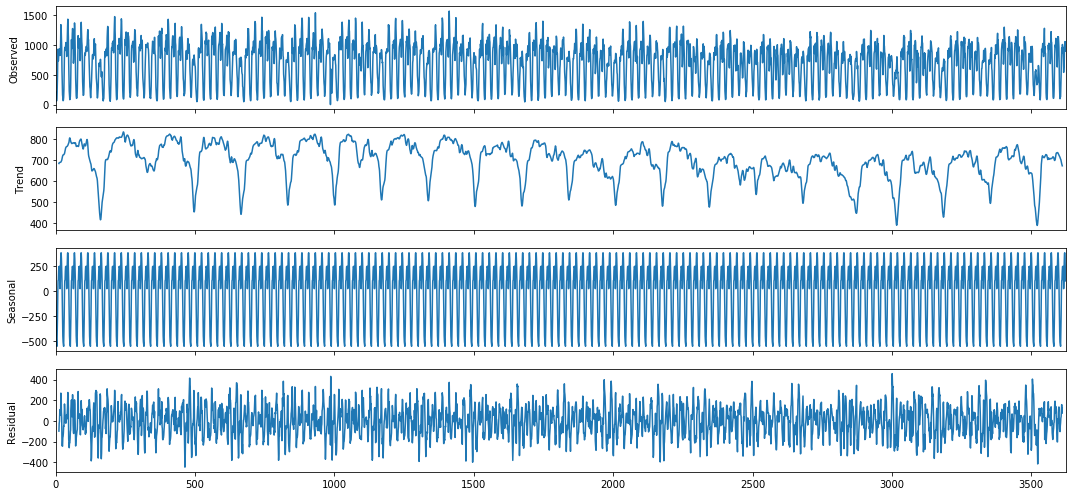

In [106]:
stl = sm.tsa.seasonal_decompose(data.raw,freq=24)
def plotseasonal(stl, axes ):
    stl.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    stl.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    stl.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    stl.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,7))

plotseasonal(stl, axes)

plt.tight_layout()
plt.show()

Видим, что как в тренде, так и в остатке еще присутствует сезонность. Попробуем, например, выделить ее из тренда. 

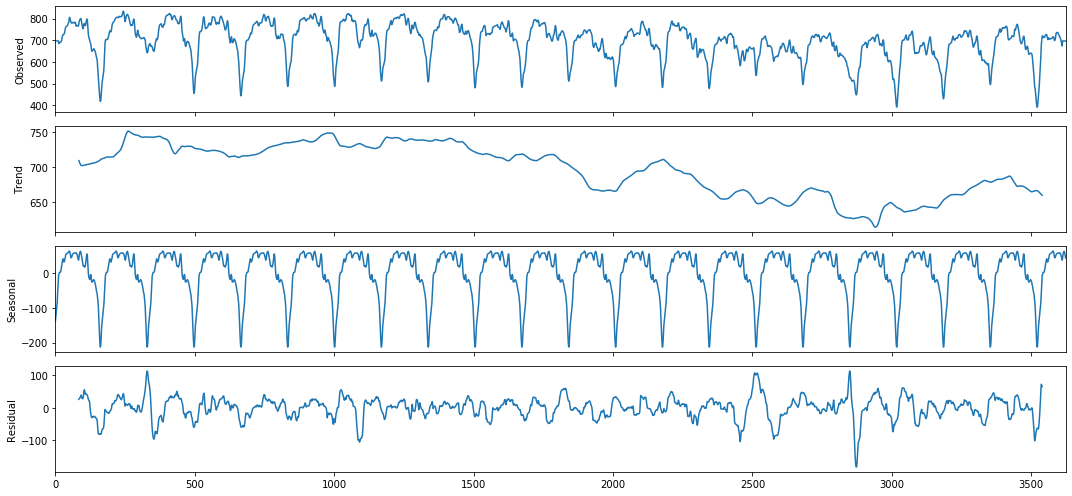

In [107]:
stl_week = sm.tsa.seasonal_decompose(stl.trend.fillna(stl.trend.mean()), freq=24*7)#неделя
def plotseasonal(stl, axes ):
    stl.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    stl.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    stl.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    stl.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,7))

plotseasonal(stl_week, axes)

plt.tight_layout()
plt.show()

Уже лучше. Как можно видеть, в тренде предыдущей декомпозиции действительно присутствовала выраженная недельная сезонность. Проведем теперь анализ графиков автокорреляции и вычислим критерий Дики-Фуллера

adf:  -7.668472513101029
p-value:  1.617284679477036e-11
ряд стационарен


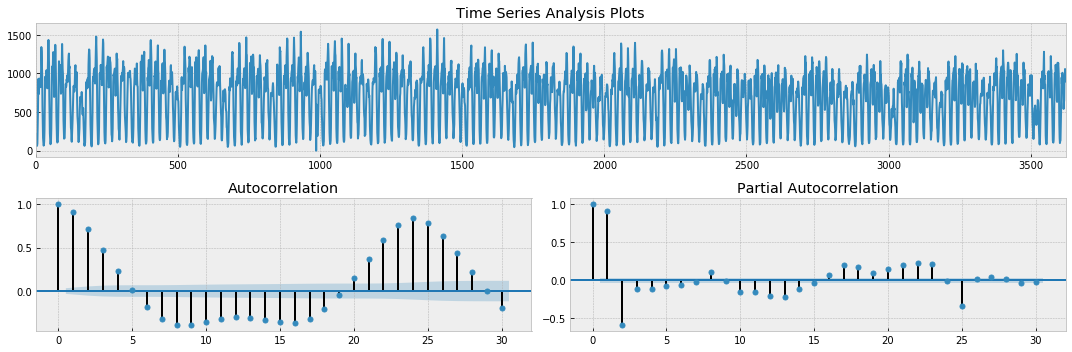

In [4]:
def tsplot(y, lags=None, figsize=(15, 5), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        test = sm.tsa.stattools.adfuller(y)
        print('adf: ', test[0]) 
        print('p-value: ', test[1])
        if test[0]> test[4]['5%']: 
            print('ряд не стационарен')
        else:
            print('ряд стационарен')
        plt.tight_layout()
    return 

tsplot(data.raw, lags=30)

Согласно результату теста DF, ряд стационарен с p<<0.05. ACF и PACF показывают значимую автокорреляцию для почти всех лагов. Выполним преобразование Бокса-Кокса, а также единичное и суточное дифференциирование.

In [5]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data['boxcox'] = data.raw.copy()
data.boxcox, lmbda = scs.boxcox(data.boxcox+1) # прибавляем единицу, так как в исходном ряде есть нули
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.970681


In [6]:
data['diff_day'] = data.raw - data.raw.shift(24)

adf:  -16.873816111379387
p-value:  1.07595091176731e-29
ряд стационарен


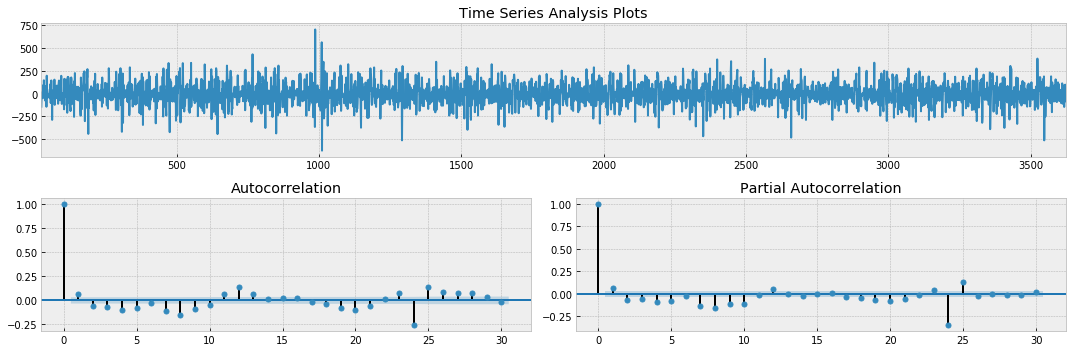

In [7]:
data['diff_1'] = data.diff_day - data.diff_day.shift(1)
tsplot(data.diff_1[24+1:], lags=30)

После всех преобразований ряд значительно больше стал похож на стационарный, однако автокорреляция все еще значима. Будем считать, что порядки дифференциирования d=1 и DS=1 для модели достаточны. 

<h3>Построение модели</h3>
Будем строить модель SARIMAX с суточной сезонностью. Чтобы учесть недельную сезонность, добавим дополнительный признак

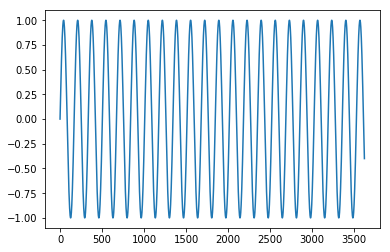

In [8]:
import math
def encode_sin(x):
    return math.sin(x*2*math.pi/168)
data['sin'] = data.index.map(encode_sin)
data['cos'] = data.index.map(lambda x: encode_sin(x+42))
plt.plot(data.sin)

Обычно, остальные гиперпараметры SARMIA подбирают, глядя на графики автокорреляции, но, в данном случае, это сделать затруднительно.  
Остальные параметры модели будем подбирать из следующего диапазона:

In [10]:
p = range(0,3)
d=1
q = range(0,3)
Ps = [7]
Ds=1
Qs = [7]

from itertools import product

parameters = product(p, q, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

9

Будем пытаться минимизировать AIC score на нашем наборе параметров. Из данных пока возьмем значения за 3 первые недели

In [11]:
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(data.boxcox.iloc[:24*7*3], 
                                        #exog = data[['sin','cos']].iloc[:24*7*3], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], Ds, param[3], 24)).fit(disp=-1)
    except ValueError:
        continue
        
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['p, q, Ps, Qs','AIC score']
result_table = result_table.sort_values(by = 'AIC score', ascending=True)
best_params = result_table.iloc[0]['p, q, Ps, Qs']
print(result_table.sort_values(by = 'AIC score', ascending=True).head())


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\2\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\2\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 11%|█████████▏                                                                         | 1/9 [07:14<57:53, 434.24s/it]C:\Users\2\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 22%|██████████████████▍                                                                | 2/9 [1

   p, q, Ps, Qs    AIC score
0  (0, 0, 7, 7)  5422.257693
4  (1, 1, 7, 7)  5437.030035
3  (1, 0, 7, 7)  5438.440803
1  (0, 1, 7, 7)  5439.808964
2  (0, 2, 7, 7)  5442.528522


Загрузим подобранные параметры в модель 5505 (4 5 5 5) 5456 (0,0,7,7) 5422

In [13]:
best_params

(0, 0, 7, 7)

In [14]:
best_model = sm.tsa.statespace.SARIMAX(data.boxcox,
                                       exog = data[['sin','cos']],
                                       order=(best_params[0], d, best_params[1]), 
                                       seasonal_order=(best_params[2], Ds, best_params[3], 24)).fit(disp=-1)
print(best_model.summary())     

C:\Users\2\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                               SARIMAX Results                                                
Dep. Variable:                                                 boxcox   No. Observations:                 3624
Model:             SARIMAX(0, 1, 0)x(7, 1, [1, 2, 3, 4, 5, 6, 7], 24)   Log Likelihood              -19689.184
Date:                                                Mon, 06 Jul 2020   AIC                          39412.368
Time:                                                        15:48:13   BIC                          39517.571
Sample:                                                             0   HQIC                         39449.861
                                                               - 3624                                         
Covariance Type:                                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

<h3>Анализ остатков</h3>
Построим график остатков модели

adf:  -19.68811524584219
p-value:  0.0
ряд стационарен


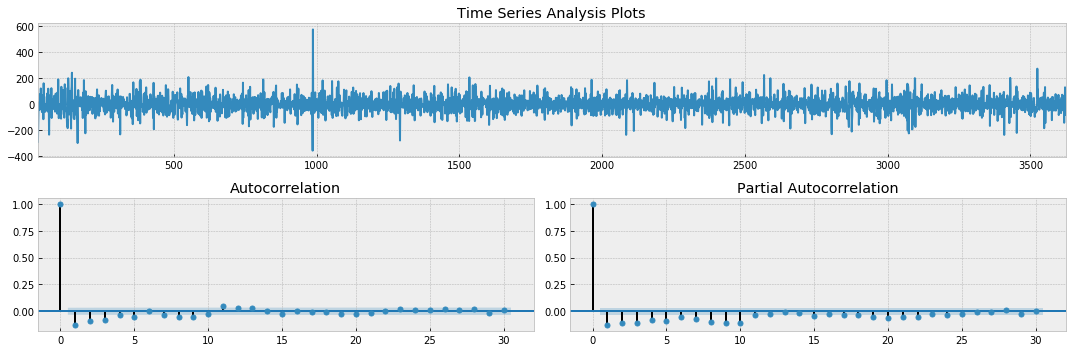

In [15]:
tsplot(best_model.resid[24:], lags=30)

Как можем видеть, остатки выглядят вполне стационарными. Посмотрим на их среднее, дисперсию и квантили

In [16]:
resid = pd.DataFrame(best_model.resid)
resid.describe()

,0
count,3624.000000
mean,-0.128370
std,58.840310
min,-357.351946
25%,-31.144272
50%,-0.490170
75%,31.109515
max,574.499728


Посмотрим на даты, в которые модель ошиблась сильнее всего, т.е. те, которые выходят за 99% квантильный размах

In [17]:
resid.quantile(.99)

0    160.113715
Name: 0.99, dtype: float64

In [32]:
resid.loc[resid[0]>160].index.map(lambda x: datetime.datetime.strptime('2016-2','%Y-%m') + datetime.timedelta(seconds=x*3600))

DatetimeIndex(['2016-02-01 00:00:00', '2016-02-01 07:00:00',
               '2016-02-01 08:00:00', '2016-02-01 19:00:00',
               '2016-02-02 20:00:00', '2016-02-04 23:00:00',
               '2016-02-06 10:00:00', '2016-02-06 23:00:00',
               '2016-02-07 10:00:00', '2016-02-08 17:00:00',
               '2016-02-15 22:00:00', '2016-02-16 21:00:00',
               '2016-02-16 23:00:00', '2016-02-18 21:00:00',
               '2016-02-23 23:00:00', '2016-03-02 22:00:00',
               '2016-03-05 21:00:00', '2016-03-13 03:00:00',
               '2016-03-14 13:00:00', '2016-03-15 22:00:00',
               '2016-03-16 20:00:00', '2016-04-04 23:00:00',
               '2016-04-22 19:00:00', '2016-04-27 23:00:00',
               '2016-05-01 23:00:00', '2016-05-09 22:00:00',
               '2016-05-10 23:00:00', '2016-05-13 00:00:00',
               '2016-05-14 20:00:00', '2016-05-17 23:00:00',
               '2016-05-18 21:00:00', '2016-05-30 10:00:00',
               '2016-06-

Сложно сказать что-либо определенное, к праздникам и дням недели ошибка вроде бы не привязана. Интересно еще посмотреть на выброс на тысячном часу, где разность достигла 600

In [21]:
resid.loc[resid[0]>500].index.map(lambda x: datetime.datetime.strptime('2016-2','%Y-%m') + datetime.timedelta(seconds=x*3600))

DatetimeIndex(['2016-03-13 03:00:00'], dtype='datetime64[ns]', freq=None)

13 марта 3 часа ночи. Видимо, какая-то аномалия.

<h3>Предсказание на графике</h3>
Построим теперь предсказание модели на одном графике с реальными данными, и предскажем на несколко дней вперед. Сначала создадим дополнительные признаки на 300 часов вперед начиная с точки, где закончилась обучающая выборка

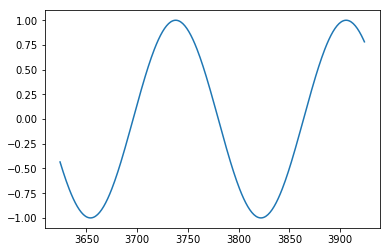

In [30]:
forecast_exog = pd.DataFrame(index = list(range(data.boxcox.shape[0],data.boxcox.shape[0]+301)))
forecast_exog['sin'] = forecast_exog.index.map(encode_sin)
forecast_exog['cos'] = forecast_exog.index.map(lambda x: encode_sin(x+42))
plt.plot(forecast_exog.sin)

C:\Users\2\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


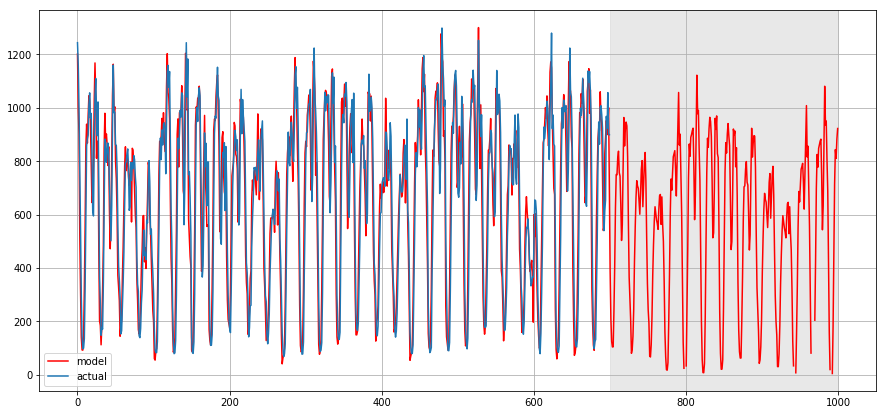

In [31]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.boxcox.shape[0],
                                        end = data.boxcox.shape[0]+300,
                                        exog = forecast_exog[['sin','cos']]), lmbda)
forecast = data.arima_model.append(forecast).values[-1000:]
actual = data.raw.values[-700:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [33]:
data.raw.describe()

count    3624.000000
mean      696.500828
std       348.863392
min         0.000000
25%       381.750000
50%       782.000000
75%       965.000000
max      1569.000000
Name: raw, dtype: float64

<h3>Вывод</h3>
Модель воспроизвела как суточную, так и недельную сезонность. Добавив гармонические признаки с большим периодом, можно также учесть месячную и годовую сезонности, но это потребует значительно большего количества данных при обучении и большей вычислительной мощности. Модель плохо описывает данные в дни, список которых приведен выше в анеализе остатков. В эти дни она ошибается более, чем на 160 поездок, т.е. на 20%. Не похоже, чтобы они были привязаны к праздникам или выходным, скорее всего, это следствие нестационарности данных.